<a href="https://colab.research.google.com/github/Eiko58/WGAN_market_simulation/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.datasets as datasets
from torch import Tensor
import numpy as np
from numpy import save
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch.nn.functional as F

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#learning_rate = 1e-4
#Batch_size = 100
#epochs = 10
#lambda_gp = 10
#critic_iter = 100

In [ ]:
!pip install POT
import ot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 664 kB 14.5 MB/s 


In [3]:
#read data file
data_message = pd.read_csv('drive/MyDrive/WGAN/LOBSTER_SampleFile_AMZN_2012-06-21_1/AMZN_2012-06-21_34200000_57600000_message_1.csv')
data_orderbook = pd.read_csv('drive/MyDrive/WGAN/LOBSTER_SampleFile_AMZN_2012-06-21_1/AMZN_2012-06-21_34200000_57600000_orderbook_1.csv')

In [ ]:
#Data preprocessing
#######Only run the first time######
#Compute TimeD in message file
x = pd.DataFrame(list(range(len(data_message))))
n_length = data_message.shape[0]
data_message.columns = ['Time','EventType','OrderID','Size','Price','Direction']
data_message['x'] = x
data_message['TimeD'] = data_message['Time'].diff()
#Compute mid-price and time in orderbook
data_orderbook.columns = ['best-ask-price','best-ask-volume','best-bid-price','best-bid-volume']
data_orderbook['mid-price'] = data_orderbook[['best-ask-price','best-bid-price']].mean(axis=1)
data = pd.concat([data_message,data_orderbook],axis=1,join='inner')
data_sub = data[['Time','best-ask-price','best-bid-price']]
data_sub['delta-bid'] = data_sub['best-bid-price'].diff()
data_sub['delta-ask'] = data_sub['best-ask-price'].diff()
data_sub['delta-bid'] = data_sub['delta-bid'].fillna(0)
data_sub['delta-ask'] = data_sub['delta-ask'].fillna(0)

index = []
for i in range(1,data_sub.shape[0]):
  if data_sub['delta-ask'][i] !=0 or data_sub['delta-bid'][i] != 0:
    index.append(i)

Time_period = [0]* n_length
for i in range(len(index)-1):
  Time_period[index[i]] = data_sub['Time'][index[i]] - data_sub['Time'][index[i]-1]
  for k in range(index[i]+1,index[i+1]):
    diff = data_sub['Time'][k] - data_sub['Time'][index[i]]
    Time_period[k] = diff
Time_period[n_length-1] = data_sub['Time'][n_length-1] - data_sub['Time'][n_length-2]
#Combine all the vectors
data_train = data[['Price','Size','Direction','TimeD','best-bid-price','best-bid-volume','best-ask-price','best-ask-volume','mid-price']]
data_train['time-period'] = Time_period
data_train['TimeD'] = data_train['TimeD'].fillna(0)
#Apply boxcox
from scipy.stats import boxcox
data_train['Size'],bestlambda1 = boxcox(data_train['Size'])
data_train['best-bid-volume'],bestlambda3 = boxcox(data_train['best-bid-volume'])
data_train['best-ask-volume'],bestlambda4 = boxcox(data_train['best-ask-volume'])
#Apply normalization
for col in data_train.columns:
  data_train[col] = 2*(data_train[col] - data_train[col].min())/(data_train[col].max() - data_train[col].min()) - 1
#Separate the data into training time series and it's target order (next order)
length = 50
train = np.empty((0,50,10))
target = np.empty((0,4))
for i in range(0,n_length - 52):
  tr = [data[i:i+length]]
  train = np.vstack((train,tr))
  t = data[i+length+1]
  target = np.vstack((target,t[0:4]))
#Save data
save('drive/MyDrive/WGAN/data_train', train)
save('drive/MyDrive/WGAN/data_target', target)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
from numpy import load
train = load('drive/MyDrive/WGAN/data_train.npy')
target = load('drive/MyDrive/WGAN/data_target.npy')

In [ ]:
#Separate data into training set and validation, test set
train_history = train[0:40000]
train_target = target[0:40000]
val_history = train[40000:50000]
val_target = target[40000:50000]
test_history = train[50000:57400]
test_target = target[50000:57400]


(40000, 50, 10)
(10000, 50, 10)
(7400, 50, 10)


In [ ]:
#Separate data only into training and test set
train_history = train[0:50000]
train_target = target[0:50000]
val_history = train[50000:57400]
val_target = target[50000:57400]

In [ ]:
#stock-GAN generator 1
class Gen1(nn.Module):
  def __init__(self, state_size,filter_size,batch_size,time_steps):
    super(Gen1, self).__init__()

    self.state_size = state_size
    self.filter_size = filter_size
    self.batch_size = batch_size
    self.time_steps = time_steps
    self.lstm1 = nn.LSTM(10, self.state_size,num_layers=1, batch_first=True)
    self.linear = nn.Linear(self.state_size*2, self.filter_size*4)
    self.name = 'Gen1'
    h_in = 8
    s = 2
    k_size = 6
    p = self.compute_padding(h_in, s, k_size)
    self.conv1 = nn.Conv1d(self.time_steps, self.time_steps,kernel_size=k_size,stride=s,padding=p)
    self.bn1 = nn.BatchNorm1d(self.time_steps)
    self.conv2 = nn.Conv1d(self.time_steps, 10, kernel_size=k_size, stride=s, padding=p)
    self.bn2 = nn.BatchNorm1d(10)
    self.conv3 = nn.Conv1d(10, 4, kernel_size=6, stride=2, padding=p)
    self.bn3 = nn.BatchNorm1d(4)
    self.conv4 = nn.Conv1d(4,1,kernel_size=9,stride=2,padding=0)
    self.out = nn.Tanh()

  def compute_padding(self, h_in, s, k_size):
    return max((h_in * (s - 2) - s + k_size) // 2, 0)

  def forward(self,y):
    x,_= self.lstm1(y)
    z = torch.randn(self.batch_size,self.time_steps).to(device)
    z = z[:,:,None].expand(self.batch_size, self.time_steps, self.state_size)
    x = torch.cat([x,z],-1)
    x = x.permute(0, 2, 1)
    x = x.reshape(self.batch_size * self.time_steps, -1)
    x = self.linear(x)
    x = x.reshape(self.batch_size,self.time_steps,self.filter_size*4)
    x = self.conv1(x)
    x = self.bn1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = self.out(x)
    x = x.reshape(self.batch_size,4)
    return x

#model = Gen1(20,32,1,50)
#input = torch.randn(1,50,10)

#out = model(input)
#print(out)

#Initialize weight
def initialize_weights(model):
  # Initializes weights according to the DCGAN paper
  for m in model.modules():
    if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.BatchNorm1d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
#CGAN1
class Gen2(nn.Module):
  def __init__(self, state_size,filter_size,batch_size,time_steps):
    super(Gen2, self).__init__()

    self.state_size = state_size
    self.filter_size = filter_size
    self.batch_size = batch_size
    self.time_steps = time_steps
    self.lstm1 = nn.LSTM(10, 1,num_layers=1, batch_first=True)
    self.linear = nn.Linear(2, 2)
    self.name = 'Gen2'
    #h_in = 8
    #s = 2
    #k_size = 6
    #p = self.compute_padding(h_in, s, k_size)
    self.Transconv1 = nn.ConvTranspose1d(self.time_steps, self.time_steps,kernel_size=4,stride=2,padding=2)
    self.bn1 = nn.BatchNorm1d(self.time_steps)
    self.Transconv2 = nn.ConvTranspose1d(self.time_steps, 10, kernel_size=4, stride=2, padding=2)
    self.bn2 = nn.BatchNorm1d(10)
    self.Transconv3 = nn.ConvTranspose1d(10, 4, kernel_size=5, stride=2, padding=2)
    self.bn3 = nn.BatchNorm1d(4)
    self.Transconv4 = nn.ConvTranspose1d(4,1,kernel_size=6,stride=1,padding=2)
    self.out = nn.Tanh()

  def compute_padding(self, h_in, s, k_size):
    return max((h_in * (s - 2) - s + k_size) // 2, 0)

  def forward(self,y):
    x,_= self.lstm1(y)
    z = torch.randn(self.batch_size,self.time_steps,1).to(device)
    #z = z[:,:,None].expand(self.batch_size, self.time_steps, self.state_size)
    x = torch.cat([x,z],-1)
    x = x.permute(0, 2, 1)
    x = x.reshape(self.batch_size * self.time_steps, -1)
    x = self.linear(x)
    x = x.reshape(self.batch_size,self.time_steps,2)
    x = self.Transconv1(x)
    x = self.bn1(x)
    x = F.relu(x)
    x = self.Transconv2(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = self.Transconv3(x)
    x = self.bn3(x)
    x = F.relu(x)
    x = self.Transconv4(x)
    x = self.out(x)
    x = x.reshape(self.batch_size,4)
    return x

#model = Gen2(20,32,1,50)
#input = torch.randn(1,50,10)

#out = model(input)
#print(out)

#Critic
class Dis2(nn.Module):
  def __init__(self, state_size,filter_size,batch_size,time_steps):
    super(Dis2, self).__init__()
    self.state_size = state_size
    self.filter_size = filter_size
    self.batch_size = batch_size
    self.time_steps = time_steps
    self.name = 'Dis2'
    self.lstm1 = nn.LSTM(4, self.state_size*2, num_layers=1, batch_first=True)
    #self.lstm2 = nn.LSTM(4, self.state_size*2, num_layers=1, batch_first= True)
    self.linear1 = nn.Linear(self.state_size*2, self.filter_size * 4)
    h_in = 8
    s = 2
    k_size = 6
    p = self.compute_padding(h_in, s, k_size)
    self.conv1 = nn.Conv1d(self.time_steps+1, self.time_steps+1, kernel_size=k_size,
                           stride=s, padding=p)
    self.bn1 = nn.BatchNorm1d(self.time_steps+1)
    self.conv2 = nn.Conv1d(self.time_steps+1, 10, kernel_size=k_size, stride=s, padding=p)
    self.bn2 = nn.BatchNorm1d(10)
    self.conv3 = nn.Conv1d(10, 4, kernel_size=6, stride=2, padding=p)
    self.bn3 = nn.BatchNorm1d(4)
    self.conv4 = nn.Conv1d(4, 1, kernel_size=9, stride=2, padding=0)
    self.bn4 = nn.BatchNorm1d(1)
    self.linear2 = nn.Linear(4,1)

  def compute_padding(self, h_in, s, k_size):
    return max((h_in * (s - 2) - s + k_size) // 2, 0)

  def forward(self,y,x):
    y = y[:,:,0:4]
    x = x.reshape(self.batch_size,1,4)
    z = torch.cat((y,x),1)
    z,_ = self.lstm1(z)
    z = self.linear1(z)
    z = self.conv1(z)
    z = self.bn1(z)
    z = F.relu(z)
    z = self.conv2(z)
    z = self.bn2(z)
    z = F.relu(z)
    z = self.conv3(z)
    z = self.bn3(z)
    z = F.relu(z)
    z = self.conv4(z)
    z = self.bn4(z)
    z = F.relu(z)
    z = self.linear2(z)
    return z

In [ ]:
#stockGAN2
class Gen3(nn.Module):
  def __init__(self, state_size,filter_size,batch_size,time_steps):
    super(Gen3, self).__init__()

    self.state_size = state_size
    self.filter_size = filter_size
    self.batch_size = batch_size
    self.time_steps = time_steps
    self.lstm1 = nn.LSTM(10, self.state_size,num_layers=1, batch_first=True)
    self.linear = nn.Linear(self.state_size*2, self.filter_size*4)
    self.name = 'Gen3'
    
    self.conv1 = nn.Conv1d(self.time_steps, self.time_steps,kernel_size=3,stride=1,padding=0)
    self.bn1 = nn.BatchNorm1d(self.time_steps)
    self.conv2 = nn.Conv1d(self.time_steps, 25, kernel_size=2, stride=2, padding=0)
    self.bn2 = nn.BatchNorm1d(25)
    self.conv3 = nn.Conv1d(25, 10, kernel_size=2, stride=1, padding=0)
    self.bn3 = nn.BatchNorm1d(10)
    self.conv4 = nn.Conv1d(10,1,kernel_size=2,stride=2,padding=1)
    self.out = nn.Tanh()

  def forward(self,y):
    x,_= self.lstm1(y)
    z = torch.randn(self.batch_size,self.time_steps).to(device)
    z = z[:,:,None].expand(self.batch_size, self.time_steps, self.state_size)
    x = torch.cat([x,z],-1)
    x = x.permute(0, 2, 1)
    x = x.reshape(self.batch_size * self.time_steps, -1)
    x = self.linear(x)
    x = x.reshape(self.batch_size,self.time_steps,self.filter_size*4)
    x = self.conv1(x)
    x = self.bn1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = self.out(x)
    x = x.reshape(self.batch_size,4)
    return x

In [ ]:
#Another critic
class Dis3(nn.Module):
  def __init__(self, state_size,filter_size,batch_size,time_steps):
    super(Dis3, self).__init__()
    self.state_size = state_size
    self.filter_size = filter_size
    self.batch_size = batch_size
    self.time_steps = time_steps
    self.name = 'Dis3'
    self.lstm1 = nn.LSTM(4, self.state_size*2, num_layers=1, batch_first=True)
    #self.lstm2 = nn.LSTM(4, self.state_size*2, num_layers=1, batch_first= True)
    self.linear1 = nn.Linear(self.state_size*2, self.filter_size * 4)
    
    self.conv1 = nn.Conv1d(self.time_steps+1, self.time_steps+1, kernel_size=3,
                           stride=1, padding=0)
    self.bn1 = nn.BatchNorm1d(self.time_steps+1)
    self.conv2 = nn.Conv1d(self.time_steps+1, 25, kernel_size=2, stride=2, padding=0)
    self.bn2 = nn.BatchNorm1d(25)
    self.conv3 = nn.Conv1d(25, 10, kernel_size=2, stride=1, padding=0)
    self.bn3 = nn.BatchNorm1d(10)
    self.conv4 = nn.Conv1d(10, 1, kernel_size=2, stride=2, padding=1)
    self.bn4 = nn.BatchNorm1d(1)
    self.linear2 = nn.Linear(4,1)


  def forward(self,y,x):
    y = y[:,:,0:4]
    x = x.reshape(self.batch_size,1,4)
    z = torch.cat((y,x),1)
    z,_ = self.lstm1(z)
    z = self.linear1(z)
    z = self.conv1(z)
    z = self.bn1(z)
    z = F.relu(z)
    z = self.conv2(z)
    z = self.bn2(z)
    z = F.relu(z)
    z = self.conv3(z)
    z = self.bn3(z)
    z = F.relu(z)
    z = self.conv4(z)
    z = self.bn4(z)
    z = F.relu(z)
    z = self.linear2(z)
    return z

In [ ]:
#Calculate gradient penalty
def gradient_penalty(critic, train, fake,device):
    # Calculate critic scores
    mixed_scores = critic(train,fake)
    gradient = torch.autograd.grad(
        inputs=fake,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [ ]:
#Training 
def train(gen,dis,batch_size,nepochs,lr_gen,lr_cri,lambda_gp,cri_it,gen_it):
  #load data
  data_train = TensorDataset(Tensor(train_history),Tensor(train_target))
  loader_train = DataLoader(data_train, batch_size = batch_size,shuffle=True)
  data_val = TensorDataset(Tensor(val_history),Tensor(val_target))
  loader_val = DataLoader(data_val, batch_size = batch_size)
  #making training folder
  print('make folders')
  full_model_name = f'{gen.name}_critic_{dis.name}_lr_gen_{lr_gen}_lr_cri_{lr_cri}_nepochs_{nepochs}_cri_it_{cri_it}_gen_it_{gen_it}_batch_{batch_size}'
  path = 'drive/MyDrive/GAN_LOB/models/'+full_model_name
  if not os.path.isdir(path):
    os.mkdir(path)
  #initialise
  opt_gen = optim.Adam(gen.parameters(),lr=lr_gen,betas=(0.0,0.9))
  opt_critic = optim.Adam(dis.parameters(), lr=lr_cri,betas=(0.0,0.6))
  epoch_gen_loss = []
  epoch_critic_loss = []
  epoch_wsd = []
  price_wsd = []
  size_wsd = []
  dir_wsd = []
  time_wsd = []
  for epoch in range(nepochs):
    for batch_idx,(train,target) in enumerate(loader_train):
      train = train.to(device)
      target = target.to(device)
      opt_critic.zero_grad()
      batch_loss_gen = []
      batch_loss_critic = []
      batch_wsd = []
      with torch.backends.cudnn.flags(enabled=False):
#Training critic
        for _ in range(cri_it):
          fake = gen(train)
          critic_real = dis(train,target)
          critic_fake = dis(train,fake)
          gp = gradient_penalty(dis,train,fake,device=device)
          loss_critic = (
              -torch.mean(critic_real) + torch.mean(critic_fake) + lambda_gp * gp
          )
          batch_loss_critic.append(loss_critic.item())
          loss_critic.backward(retain_graph=True)
          opt_critic.step()
        #for _ in range(gen_it):
#Training generator
        opt_gen.zero_grad()
        gen_fake = dis(train,fake)
        loss_gen = -torch.mean(gen_fake)
        batch_loss_gen.append(loss_gen.item())
        loss_gen.backward()
        opt_gen.step()
#Compute sliced wasserstein distance
        wsd = ot.sliced_wasserstein_distance(target.cpu().detach().numpy(),fake.cpu().detach().numpy())
        batch_wsd.append(wsd)
#print info
        if batch_idx % 100 == 0 and batch_idx >0:
          print(
              f"Epoch [{epoch+1}/{nepochs}] Batch {batch_idx}/{len(loader_train)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}, WSD:{wsd}"
          )
#Save info
    epoch_critic_loss.append(np.mean(np.array(batch_loss_critic)))
    epoch_gen_loss.append(np.mean(np.array(batch_loss_gen)))
    epoch_wsd.append(np.mean(np.array(batch_wsd)))
#Every 10 epochs, do prediction on validation set and save results
    if (epoch+1) % 10 == 0 or epoch == 0:
        real = torch.tensor([0.,0.,0.,0.]).reshape(1,4).to(device)
        new = torch.tensor([0.,0.,0.,0.]).reshape(1,4).to(device)
        with torch.no_grad():
          for i,(train,target) in enumerate(loader_val):
            train = train.to(device)
            target = target.to(device)
            fake = gen(train)
            real = torch.cat((real,target),dim=0)
            new = torch.cat((new,fake),dim=0)
        val_real = real.cpu().detach().numpy()[1:,:]
        val_new = new.cpu().detach().numpy()[1:,:]
        if (epoch+1) == nepochs:
          np.savetxt("real.csv", val_real, delimiter=",")
          np.savetxt("fake.csv", val_new, delimiter=",")

        price = np.column_stack((val_real[:,0],val_new[:,0]))
        size = np.column_stack((val_real[:,1],val_new[:,1]))
        direction = np.column_stack((val_real[:,2],val_new[:,2]))
        timeint = np.column_stack((val_real[:,3],val_new[:,3]))
        
        price_wsd.append(ot.sliced_wasserstein_distance(np.reshape(price[:,0],(1,7400)),np.reshape(price[:,1],(1,7400))))
        size_wsd.append(ot.sliced_wasserstein_distance(size[:,0].reshape((1,7400)),size[:,1].reshape((1,7400))))
        dir_wsd.append(ot.sliced_wasserstein_distance(direction[:,0].reshape((1,7400)),direction[:,1].reshape((1,7400))))
        time_wsd.append(ot.sliced_wasserstein_distance(timeint[:,0].reshape((1,7400)),timeint[:,1].reshape((1,7400))))

        image_price_name = f'/validation_price_{epoch+1}_.png'
        image_size_name = f'/validation_size_{epoch+1}_.png'
        image_direction_name = f'/validation_direction_{epoch+1}_.png'
        image_timeint_name = f'/validation_timeint_{epoch+1}_.png'
        fig_price = sns.histplot(price,kde=True).set(title='price')
        plt.savefig(path+image_price_name)
        plt.close()
        fig_size = sns.histplot(size,kde=True).set(title='size')
        plt.savefig(path+image_size_name)
        plt.close()
        fig_dir = sns.histplot(direction,kde=True).set(title='direction')
        plt.savefig(path+image_direction_name)
        plt.close()
        fig_time = sns.histplot(timeint,kde=True).set(title='timeint')
        plt.savefig(path+image_timeint_name)
        plt.close()
#save all the training info
  d = {}
  d['gen_loss'] = epoch_gen_loss
  d['critic_loss'] = epoch_critic_loss
  d['wsd'] = epoch_wsd
  df = pd.DataFrame(d)
  df.to_csv(path+'/losses.txt')  

  wsd_val = {}
  wsd_val['price'] = price_wsd
  wsd_val['size'] = size_wsd
  wsd_val['direction'] = dir_wsd
  wsd_val['timeint'] = time_wsd

  wsd_val_df = pd.DataFrame(wsd_val)
  wsd_val_df.to_csv(path+'/val_wsd.txt')




In [ ]:
#training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gen = Gen2(10,32,100,50).to(device)
critic = Dis2(10,32,100,50).to(device)
initialize_weights(gen)
initialize_weights(critic)
train(gen,critic,batch_size=100,nepochs=120,lr_gen=0.0001,lr_cri=0.0001,lambda_gp=10,cri_it=1,gen_it=1)


make folders
Epoch [1/120] Batch 100/500                   Loss D: 9.8044, loss G: 0.1086, WSD:0.9171605336586383
Epoch [1/120] Batch 200/500                   Loss D: 9.4121, loss G: 0.1027, WSD:0.8655499848164824
Epoch [1/120] Batch 300/500                   Loss D: 9.2620, loss G: 0.0988, WSD:0.9124594699041557
Epoch [1/120] Batch 400/500                   Loss D: 9.3106, loss G: 0.1021, WSD:0.9326051190974052
Epoch [2/120] Batch 100/500                   Loss D: 9.3293, loss G: 0.1118, WSD:0.8709047095172567
Epoch [2/120] Batch 200/500                   Loss D: 9.2804, loss G: 0.1084, WSD:0.9069221582189243
Epoch [2/120] Batch 300/500                   Loss D: 7.7713, loss G: 0.1101, WSD:0.8224900161976201
Epoch [2/120] Batch 400/500                   Loss D: 8.3468, loss G: 0.1095, WSD:0.816170988412309
Epoch [3/120] Batch 100/500                   Loss D: 9.1830, loss G: 0.1105, WSD:0.8697258146819097
Epoch [3/120] Batch 200/500                   Loss D: 8.8269, loss G: 0.1104, W

In [11]:
loss2 = pd.read_csv('drive/MyDrive/GAN_LOB/models/Gen3_critic_Dis2_lr_gen_0.0001_lr_cri_0.0001_nepochs_100_cri_it_1_gen_it_1_batch_100/losses.txt')
wsd_2 = pd.read_csv('drive/MyDrive/GAN_LOB/models/Gen3_critic_Dis2_lr_gen_0.0001_lr_cri_0.0001_nepochs_100_cri_it_1_gen_it_1_batch_100/val_wsd.txt')

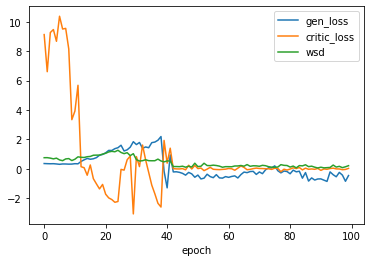

In [12]:
#plot the loss
loss2.rename(columns={"Unnamed: 0": "epoch"}, inplace=True)
loss2.plot(x="epoch" , y=["gen_loss", "critic_loss", "wsd"])
plt.show()

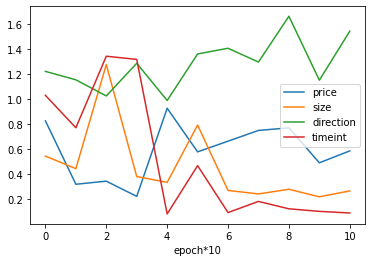

In [13]:
#plot sliced wasserstein distance
wsd_2.rename(columns={"Unnamed: 0": "epoch*10"}, inplace=True)
wsd_2.plot(x="epoch*10",y=["price","size","direction","timeint"])
plt.show()